# Image Processing and Computer Vision Project - Alberico Arcangelo

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
from sklearn.cluster import DBSCAN

## Step A - Multiple Product Detection
The first task is to develop an object detection system to identify single instance of products given: one reference image for each item and a scene image. This goal can be reached through the dectection of **local invariant features** and then matching the **keypoints**.

I first load the images and apply some image processing to the scenes in order to improve them. Then, I compute with **SIFT** all the keypoints and the descriptors of the products and the scenes in advance.

In [2]:
test_scenes = [1, 2, 3, 4, 5]
prod_images = [0, 1, 11, 19, 24, 25, 26]

dict_prod = {}
for prod in prod_images:
    # Load the product image both colour and grayscale
    img_prod = cv2.imread('models/'+str(prod)+'.jpg', cv2.IMREAD_COLOR)
    img_prod_gr = cv2.cvtColor(img_prod, cv2.COLOR_BGR2GRAY)
    
    # Detecting keypoints and computing the descriptors for each keypoints in the product image
    sift = cv2.xfeatures2d.SIFT_create()
    kp_p, des_p = sift.detectAndCompute(img_prod_gr, None)
    dict_prod[prod] = (img_prod, img_prod_gr, kp_p, des_p)


dict_scene = {}
for scene in test_scenes:
    # Load the scene image both colour and grayscale
    img_scene = cv2.imread('scenes/e'+str(scene)+'.png', cv2.IMREAD_COLOR)
    img_scene_gr = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY)
    
    # Equalize the histogram to improve the contrast
    img_scene_eq = cv2.equalizeHist(img_scene_gr)
    
    # Sharpen the image by convolving with the sharpen kernel
    sharpen_kernel = np.array([
                [0,-1,0],
                [-1,5,-1],
                [0,-1,0]])
    img_scene_pre = cv2.filter2D(img_scene_eq,-1,sharpen_kernel)
    img_scene_pre = np.abs(img_scene_pre)
    
    # Detecting keypoints and computing the descriptors for each keypoints in the scene image
    sift = cv2.xfeatures2d.SIFT_create()
    kp_s, des_s = sift.detectAndCompute(img_scene_pre, None)
    dict_scene[scene] = (img_scene, img_scene_gr, kp_s, des_s)


I run the **K Nearest Neighbour Flann Matcher**, which is an approximate kd-tree matching algorithm, and then I compute the homography with the found matches from the model to the scene.

After this, the potential found boxes undergo a rectangulirity check in order to discard the low ones.

In [3]:
result_scene = {}
for scene in test_scenes:
    
    img_scene, img_scene_gr, kp_s, des_s = dict_scene[scene]
    
    result_prod = {}
    for prod in prod_images:
        img_prod, img_prod_gr, kp_p, des_p = dict_prod[prod]
        
        # Initializing the matching algorithm
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        # Matching the descriptors
        matches = flann.knnMatch(des_p,des_s,k=2)

        # Keeping only good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)

        # If we have at least MIN_MATCH_COUNT matches we find the box of the object
        MIN_MATCH_COUNT = 80
        out_scene = False
        if len(good)>MIN_MATCH_COUNT:
            src_pts = np.float32([ kp_p[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_s[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

            # Calculating homography based on correspondences
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)

            # Matches mask for visualization of only matches used by RANSAC
            matchesMask = mask.ravel().tolist()

            # Apply homography to project corners of the query image into the image
            h,w = img_prod_gr.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)

            # Calculate the bounding box
            x, y, w, h = cv2.boundingRect(dst)
            
            # Check rectangularity
            bounds_area = cv2.contourArea(dst)
            rect_area = w * h
            rectangularity = bounds_area / rect_area
            
            # Check if it's inside the scene
            for pt in dst:
                if pt[0][0] < -90 or pt[0][1] < -90:
                    out_scene = True
            
            if rectangularity > 0.9 and not out_scene:
                if prod in result_prod.keys():
                    result_prod[prod].append(dst)
                else:
                    result_prod[prod] = [dst]

        else:
            #print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            matchesMask = None
        
        result_scene[scene] = result_prod

To filter out incorret matches due to similar products (for example the Nesquik boxes `0` and `26` are often matched both in the same box in the scene) I check if the barycenter of a box is contained in another box and then remove the one with smaller area

In [4]:
for s in result_scene:
    poss_overlap = []
    for p1 in result_scene[s]:
        n = len(result_scene[s][p1])
        for i in range(n):
            x, y, w, h = cv2.boundingRect(result_scene[s][p1][i])
            center = ((x + w // 2), (y + h // 2))
            p1_area = cv2.contourArea(result_scene[s][p1][i])
            for p2 in result_scene[s]:
                if p1 < p2:
                    n2 = len(result_scene[s][p2])
                    for i2 in range(n2):
                        x2, y2, w2, h2 = cv2.boundingRect(result_scene[s][p2][i2])
                        p2_area = cv2.contourArea(result_scene[s][p2][i2])
                        if (x2<=center[0]<=x2+w2) and (y2<=center[1]<=y2+h2):
                            if p1_area <= p2_area:
                                result_scene[s][p1][i] = []
                            else:
                                result_scene[s][p2][i2] =[]
                            
for s in result_scene:
    for p in result_scene[s]:
        result_scene[s][p] = [x for x in result_scene[s][p] if len(x)!=0]        
    result_scene[s] = {k: v for k, v in result_scene[s].items() if v}

The following cell shows for each matched product the relative position in each scene 

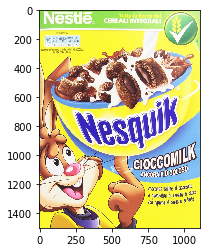

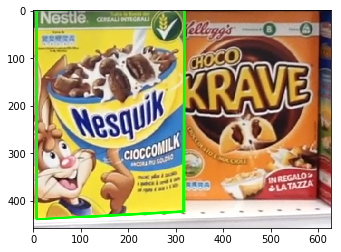

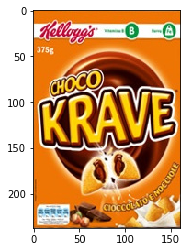

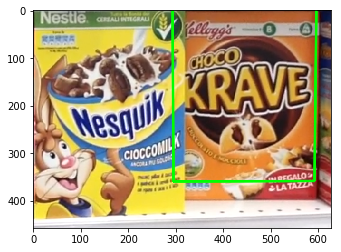

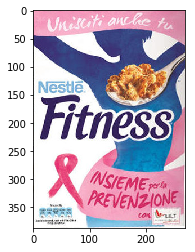

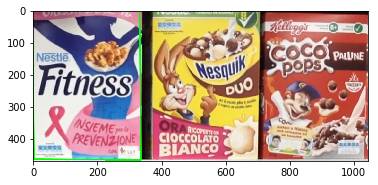

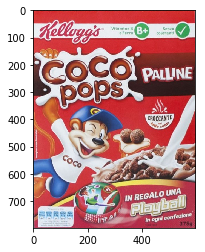

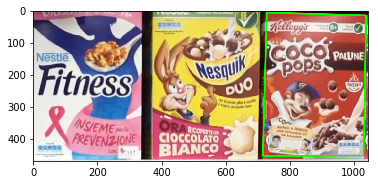

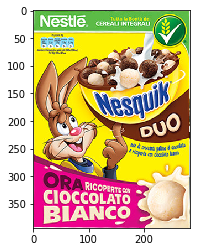

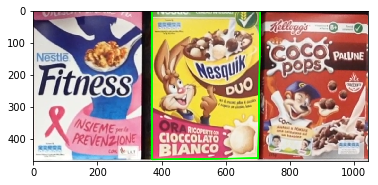

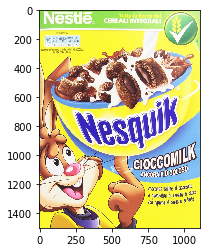

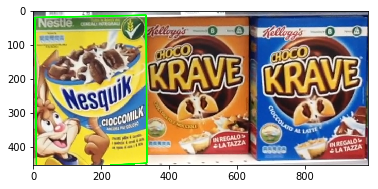

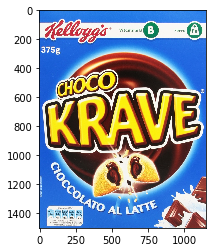

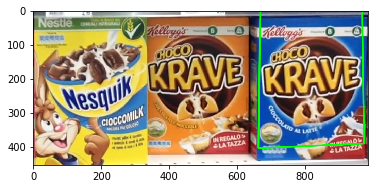

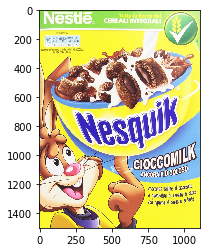

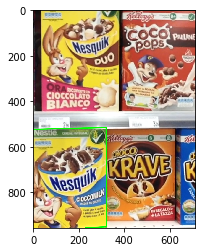

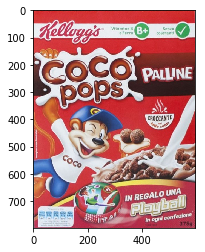

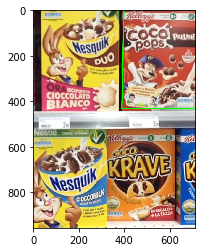

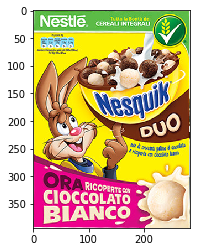

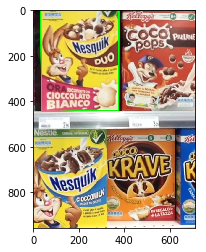

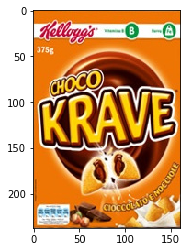

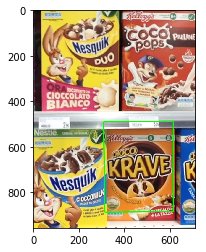

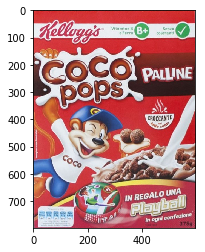

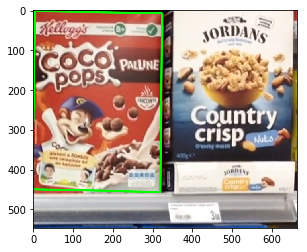

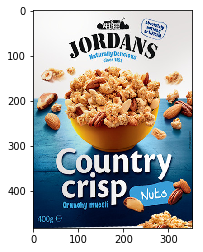

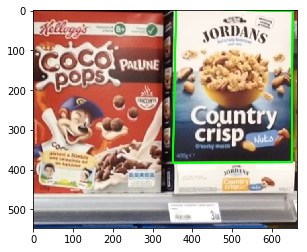

In [5]:
# Drawing bounding box
for s in result_scene.keys():
    for p in result_scene[s].keys():
        plt.imshow(cv2.cvtColor(dict_prod[p][0],cv2.COLOR_BGR2RGB))
        plt.show()
        final_img = dict_scene[s][0].copy()
        final_img = cv2.polylines(final_img,np.int32([result_scene[s][p][0]]),True,(0,255,0), 3, cv2.LINE_AA)
        final_img_rgb = cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB)
        plt.imshow(final_img_rgb)
        plt.show()

The following cell outputs the result as requested in the project description

In [6]:
# Print results
for s in result_scene.keys():
    print('Scene '+str(s))
    
    for p in result_scene[s].keys():
        n = len(result_scene[s][p])
        print('\tProduct '+str(p)+' - '+str(n)+' instance found:')
        
        for i in range(n):
            x, y, w, h = cv2.boundingRect(result_scene[s][p][i])
            center = ((x + w // 2), (y + h // 2))
            print('\t\tInstance '+str(i+1)+' {position: '+str(center)+', width: '+str(w)+'px, height: '+str(h)+'px}')
        

Scene 1
	Product 0 - 1 instance found:
		Instance 1 {position: (163, 217), width: 312px, height: 445px}
	Product 11 - 1 instance found:
		Instance 1 {position: (445, 165), width: 304px, height: 391px}
Scene 2
	Product 24 - 1 instance found:
		Instance 1 {position: (167, 218), width: 340px, height: 496px}
	Product 25 - 1 instance found:
		Instance 1 {position: (877, 230), width: 323px, height: 446px}
	Product 26 - 1 instance found:
		Instance 1 {position: (540, 218), width: 338px, height: 491px}
Scene 3
	Product 0 - 1 instance found:
		Instance 1 {position: (170, 239), width: 329px, height: 454px}
	Product 1 - 1 instance found:
		Instance 1 {position: (818, 198), width: 312px, height: 412px}
Scene 4
	Product 0 - 1 instance found:
		Instance 1 {position: (158, 741), width: 329px, height: 453px}
	Product 25 - 1 instance found:
		Instance 1 {position: (554, 207), width: 331px, height: 453px}
	Product 26 - 1 instance found:
		Instance 1 {position: (204, 196), width: 345px, height: 498px}
	P

As we can see the only error that the model makes is that it cannot recognize in the scene `e3` the product `11`

## Step B - Multiple Instance Detection
The second task is to develop an object detection system to identify multiple instance of products given. To reach this goal the **Generalized Hough Transform (GHT)** has to be used combined with SIFT key-points to find correspondences between scene and models.

In [7]:
test_scenes = [1, 2, 3, 4, 5]
prod_images = [0, 1, 11, 19, 24, 25, 26]

dict_prod = {}
for prod in prod_images:
    # Load the product image both colour and grayscale
    img_prod = cv2.imread('models/'+str(prod)+'.jpg', cv2.IMREAD_COLOR)
    img_prod_gr = cv2.cvtColor(img_prod, cv2.COLOR_BGR2GRAY)
    
    # Detecting keypoints and computing the descriptors for each keypoints in the product image
    sift = cv2.xfeatures2d.SIFT_create()
    kp_p, des_p = sift.detectAndCompute(img_prod_gr, None)
    
    # Compute the barycenter for the GHT
    x = np.mean([kp.pt[0] for kp in kp_p])
    y = np.mean([kp.pt[1] for kp in kp_p])
    barycen_p = [x,y]
    
    dict_prod[prod] = (img_prod, img_prod_gr, kp_p, des_p, barycen_p)


dict_scene = {}
for scene in test_scenes:
    # Load the scene image both colour and grayscale
    img_scene = cv2.imread('scenes/m'+str(scene)+'.png', cv2.IMREAD_COLOR)
    img_scene_gr = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY)
    
    # Equalize the histogram to improve the contrast
    img_scene_eq = cv2.equalizeHist(img_scene_gr)
    
    # Sharpen the image by convolving with the sharpen kernel
    sharpen_kernel = np.array([
                [0,-1,0],
                [-1,5,-1],
                [0,-1,0]])
    img_scene_pre = cv2.filter2D(img_scene_eq,-1,sharpen_kernel)
    img_scene_pre = np.abs(img_scene_pre)
    
    # Detecting keypoints and computing the descriptors for each keypoints in the scene image
    sift = cv2.xfeatures2d.SIFT_create()
    kp_s, des_s = sift.detectAndCompute(img_scene_pre, None)
    dict_scene[scene] = (img_scene, img_scene_gr, kp_s, des_s)


As done in the previous step, I run the **FLANN** matching algorithm to find the matching keypoints. 

Then **GHT** is applied considering the barycenter of the product image as the reference point to compute the joining vectors which is scaled and rotated according to the ratio of the scales and the difference of the orientations of the matching keypoints. This vector is applyed to the scene to cast a vote into an **Accumulator Array (AA)** to find the points that are more likely to coincide with the actual barycenter of the box in the image. The AA matrix has also been quantized by a factor of 5 in order to aggregate votes into single and nearer points.

To find clusters of points, which reflect the presence of the product in the scene, the **DBSCAN** clustering algorithm is applied on the non empty entries of the AA matrix and, after thresholding the number of points found in each cluster, the homography is computed warping the box into the scene.


In [8]:
result_scene = {}
for scene in test_scenes:
    
    img_scene, img_scene_gr, kp_s, des_s = dict_scene[scene]
    
    result_prod = {}
    for prod in prod_images:
        img_prod, img_prod_gr, kp_p, des_p, barycen_p = dict_prod[prod]
        
        # Initializing the matching algorithm
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        # Matching the descriptors
        matches = flann.knnMatch(des_p,des_s,k=2)

        # Keeping only good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)

        # Online phase of the GHT algorithm
        aa_quant_fact = 5
        aa_matrix = np.zeros((img_scene_gr.shape[0]//aa_quant_fact, img_scene_gr.shape[1]//aa_quant_fact))
        dict_matches = {}

        for m in good:
            # Retrieve only good matches
            kp_p_good = kp_p[m.queryIdx]
            kp_s_good = kp_s[m.trainIdx]

            # Compute the vector that connects each keypoint to the barycenter
            vec = np.subtract(barycen_p, kp_p_good.pt)

            # Scale the vector 
            vec_scaled = np.multiply(vec, kp_s_good.size/kp_p_good.size)

            # Rotate the vector
            rot_angle = math.radians(kp_s_good.angle - kp_p_good.angle)
            rot_matrix = np.array(((np.cos(rot_angle), -np.sin(rot_angle)),(np.sin(rot_angle), np.cos(rot_angle))))
            vec_scaled_rot = rot_matrix.dot(vec_scaled)

            # Calculate barycenter
            bar_x = int(round(kp_s_good.pt[0] + vec_scaled_rot[0])//aa_quant_fact)
            bar_y = int(round(kp_s_good.pt[1] + vec_scaled_rot[1])//aa_quant_fact)

            bar = (bar_x, bar_y)
            if bar in dict_matches.keys():
                dict_matches[bar].append(m)
            else:
                dict_matches[bar] = [m]

            # Cast a vote
            if 0 <= bar[0] < aa_matrix.shape[1] and 0 <= bar[1] < aa_matrix.shape[0]:
                aa_matrix[bar[1], bar[0]] += 1
            
        # Find clusters
        # Take non zero values from the aa_matrix
        non_null=np.concatenate((np.nonzero(aa_matrix)[1].reshape((-1,1)), np.nonzero(aa_matrix)[0].reshape((-1,1))), axis=1)
        
        # In order to take into account votes I add the same point many time as 
        # the respective value of the aa_matrix is 
        non_null_ext = []
        for i in range(non_null.shape[0]):
            for j in range(int(aa_matrix[non_null[i,1],non_null[i,0]])):
                non_null_ext.append(non_null[i].tolist())
        non_null_ext = np.array(non_null_ext)
        
        # Apply DBSCAN to find the clusters
        y = DBSCAN(eps=15, min_samples=20).fit_predict(non_null_ext)
        cluster_labels_all = np.unique(y)
        cluster_labels = cluster_labels_all[cluster_labels_all != -1]
        n_clusters = len(cluster_labels)
        cl = []
        for i in cluster_labels:
            cl.append(non_null_ext[y==i].tolist())

        for instance in cl:
            instance_matches = []
            for pt in instance:
                instance_matches += dict_matches[tuple(pt)]
            
            
            # If I have at least MIN_POINT_COUNT matches we find the box of the object
            MIN_POINT_COUNT = 30
            out_scene = False
            if len(instance_matches) > MIN_POINT_COUNT:
                src_pts = np.float32([ kp_p[m.queryIdx].pt for m in instance_matches ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp_s[m.trainIdx].pt for m in instance_matches ]).reshape(-1,1,2)

                # Calculating homography based on correspondences
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)

                # Matches mask for visualization of only matches used by RANSAC
                matchesMask = mask.ravel().tolist()

                # Apply homography to project corners of the query image into the image
                h,w = img_prod_gr.shape
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                dst = cv2.perspectiveTransform(pts,M)

                # Calculate the bounding box
                x, y, w, h = cv2.boundingRect(dst)
                
                # Check rectangularity
                bounds_area = cv2.contourArea(dst)
                rect_area = w * h
                rectangularity = bounds_area / rect_area

                # Check if it's inside the scene
                for pt in dst:
                    if pt[0][0] < -90 or pt[0][1] < -90:
                        out_scene = True

                if rectangularity > 0.8 and not out_scene:
                    if prod in result_prod.keys():
                        result_prod[prod].append(dst)
                    else:
                        result_prod[prod] = [dst]

            else:
                #print( "Not enough matches are found - {}/{}".format(len(instance_matches), MIN_POINT_COUNT) )
                matchesMask = None

        result_scene[scene] = result_prod

To filter out incorret matches due to similar products (for example the Nesquik boxes `0` and `26` are often matched both in the same box in the scene) I check if the barycenter of a box is contained in another box and then remove the one with smaller area

In [9]:
for s in result_scene:
    poss_overlap = []
    for p1 in result_scene[s]:
        n = len(result_scene[s][p1])
        for i in range(n):
            x, y, w, h = cv2.boundingRect(result_scene[s][p1][i])
            center = ((x + w // 2), (y + h // 2))
            p1_area = cv2.contourArea(result_scene[s][p1][i])
            for p2 in result_scene[s]:
                if p1 < p2:
                    n2 = len(result_scene[s][p2])
                    for i2 in range(n2):
                        x2, y2, w2, h2 = cv2.boundingRect(result_scene[s][p2][i2])
                        p2_area = cv2.contourArea(result_scene[s][p2][i2])
                        if (x2<=center[0]<=x2+w2) and (y2<=center[1]<=y2+h2):
                            if p1_area <= p2_area:
                                result_scene[s][p1][i] = []
                            else:
                                result_scene[s][p2][i2] =[]
                            
for s in result_scene:
    for p in result_scene[s]:
        result_scene[s][p] = [x for x in result_scene[s][p] if len(x)!=0]        
    result_scene[s] = {k: v for k, v in result_scene[s].items() if v}

The following cell shows for each matched product the relative position in each scene 

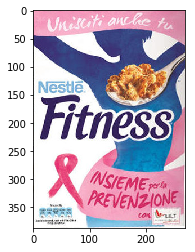

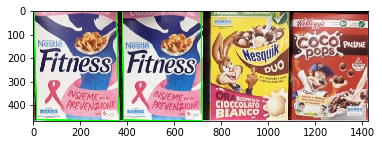

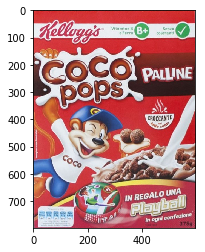

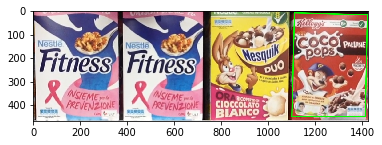

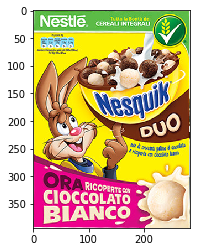

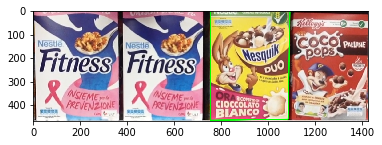

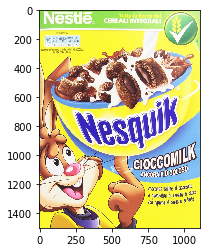

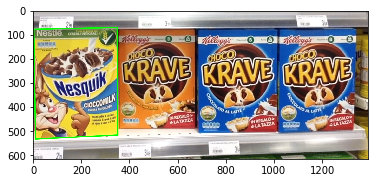

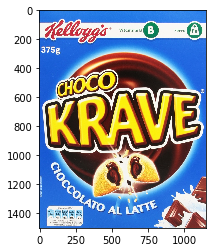

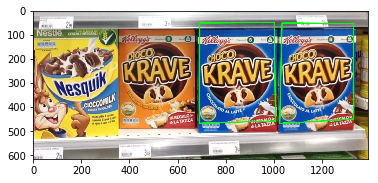

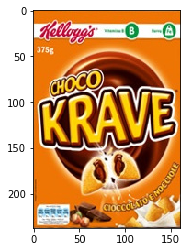

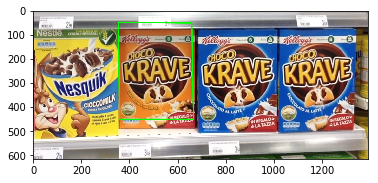

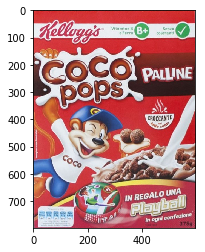

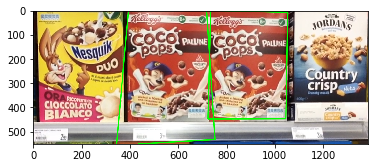

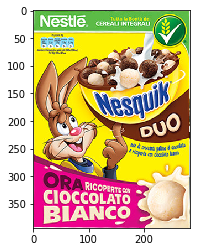

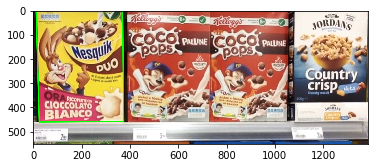

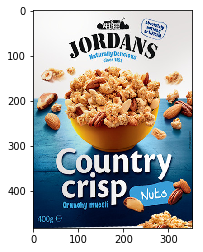

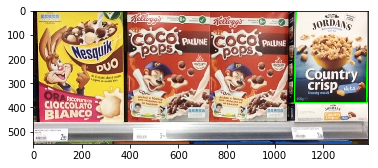

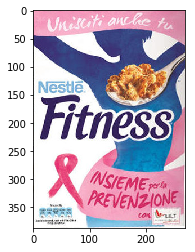

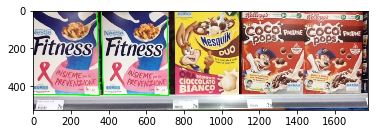

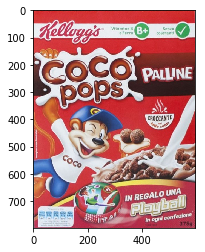

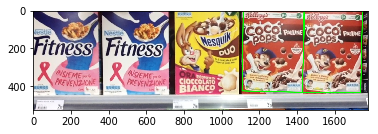

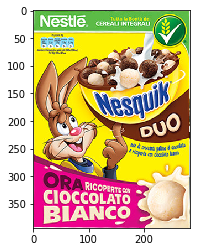

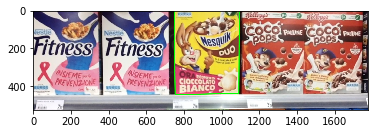

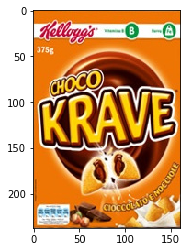

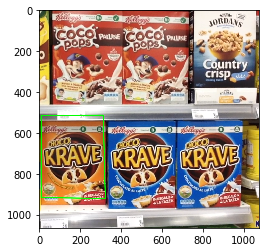

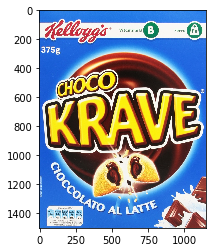

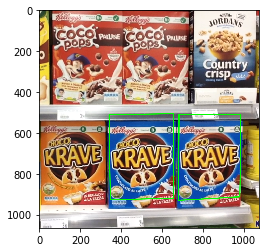

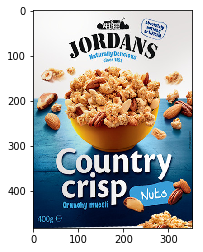

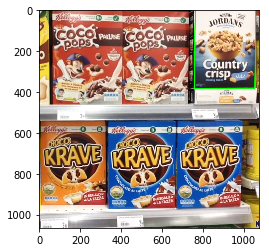

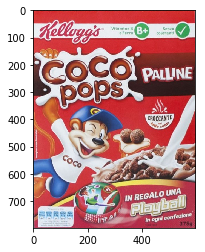

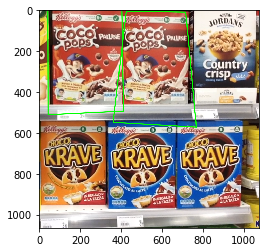

In [10]:
for s in result_scene.keys():
    for p in result_scene[s].keys():
        n = len(result_scene[s][p])
        plt.imshow(cv2.cvtColor(dict_prod[p][0],cv2.COLOR_BGR2RGB))
        plt.show()
        final_img = dict_scene[s][0].copy()
        for i in range(n):
            final_img = cv2.polylines(final_img,np.int32([result_scene[s][p][i]]),True,(0,255,0), 3, cv2.LINE_AA)
        final_img_rgb = cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB)
        plt.imshow(final_img_rgb)
        plt.show()

The following cell outputs the result as requested in the project description

In [11]:
# Print results
for s in result_scene.keys():
    print('Scene '+str(s))
    
    for p in result_scene[s].keys():
        n = len(result_scene[s][p])
        print('\tProduct '+str(p)+' - '+str(n)+' instance found:')
        
        for i in range(n):
            x, y, w, h = cv2.boundingRect(result_scene[s][p][i])
            center = ((x + w // 2), (y + h // 2))
            print('\t\tInstance '+str(i+1)+' {position: '+str(center)+', width: '+str(w)+'px, height: '+str(h)+'px}')
        

Scene 1
	Product 24 - 2 instance found:
		Instance 1 {position: (185, 212), width: 365px, height: 507px}
		Instance 2 {position: (549, 218), width: 341px, height: 496px}
	Product 25 - 1 instance found:
		Instance 1 {position: (1261, 228), width: 322px, height: 442px}
	Product 26 - 1 instance found:
		Instance 1 {position: (923, 218), width: 339px, height: 491px}
Scene 2
	Product 0 - 1 instance found:
		Instance 1 {position: (178, 303), width: 350px, height: 462px}
	Product 1 - 2 instance found:
		Instance 1 {position: (1178, 261), width: 308px, height: 417px}
		Instance 2 {position: (849, 260), width: 316px, height: 418px}
	Product 11 - 1 instance found:
		Instance 1 {position: (511, 251), width: 312px, height: 402px}
Scene 3
	Product 25 - 2 instance found:
		Instance 1 {position: (888, 225), width: 331px, height: 447px}
		Instance 2 {position: (549, 273), width: 408px, height: 566px}
	Product 26 - 1 instance found:
		Instance 1 {position: (193, 205), width: 365px, height: 511px}
	Prod

As we can see from the results the model detects correctly all the instances of the products in the scenes